# Diffusion Model for Video Super Resolution

Inspiration gathered from:

https://github.com/CompVis/latent-diffusion

https://ar5iv.labs.arxiv.org/html/2311.15908

In [30]:
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F # provides functions that don't need to be in a computational graph, i.e. aren't part of a NN, usually for single-use
import torchvision
from torch.utils.data import DataLoader, Dataset
from model import *
import matplotlib.pyplot as plt
import time as time
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
PYTORCH_NO_CUDA_MEMORY_CACHING=1
set('PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512')
set('PYTORCH_ENABLE_MPS_FALLBACK=1')

"""
if matplotlib doesn't run, go into the envs/pytorch_vsr environment in anaconda3
and delete all version of libiomp5md.dll , and it should work
"""

if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps") # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available
# device = 'cpu'
print(f"Using device: {device}")

Using device: mps


In [31]:
torchvision.__version__

'0.15.1'

In [32]:
# # datasets with _sharp are the correct/ground truth images
# # datasets with _blur_bicubic are those that have been blurred and
# # downsampled using bicubic interpolation
# datasets = ['train_sharp', 'train_blur_bicubic', 'val_sharp', 'val_blur_bicubic']
# for set in datasets:
#     print(set)
#     if not os.path.isfile(f"REDS/{set}.zip"):
#         # print("Downloading")
#         cmdlet = f"python download_REDS.py --{set}"
#         print(cmdlet)
#         os.system(cmdlet)
# # if not already downloaded, this will download all datasets (takes a while)
# 
# # Set up data into dataset and dataloader
# # It assumes the project file structure as downloaded from above
# # Built based on docs: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# class REDS(Dataset):
#     def __init__(self, train=True, device='cuda'):
#         self.device = device
#         self.type = 'train' if train else 'test' 
#         if self.type == 'train':
#             self.hr_dir = "REDS/train_sharp/train/train_sharp"
#             self.lr_dir = "REDS/train_blur_bicubic/train/train_blur_bicubic/X4"
#         else:
#             self.hr_dir = "REDS/val_sharp/val/val_sharp"
#             self.lr_dir = "REDS/val_blur_bicubic/val/val_blur_bicubic/X4"
#             
#     def __len__(self):
#         return len(os.listdir(self.hr_dir)) # training size = 240 videos, testing size = 30 videos
#             
#     def __getitem__(self, idx):
#         # each return gives a single HR frame with 5 corresponding LR frames
#         # the middle LR frame (frame 3) will be the blurred/downsampled version of the HR frame
#         # the 5 sequential LR frames will be chosen randomly from the given idx-video
#         
#         # Getting video sequence folder name
#         if idx < 10:
#             video = '00' + str(idx)
#         elif idx < 100:
#             video = '0' + str(idx)
#         else:
#             video = str(idx)
#         # Getting random sequence of 5 LR frames from the video    
#         num_video_frames = len(os.listdir(f"{self.hr_dir}/000"))
#         rand_frame_id = np.random.randint(2, num_video_frames - 2)
#         lr_frame_idx = []
#         for i in range(-2, 3):
#             id_int = rand_frame_id + i
#             if id_int < 10:
#                 id_str = '0000000' + str(id_int)
#             elif id_int < 100:
#                 id_str = '000000' + str(id_int)
#             else:
#                 id_str = '00000' + str(id_int)
#             lr_frame_idx.append(id_str)
#         # Actually reading in the images
#         hr_frame = torchvision.io.read_image(f"{self.hr_dir}/{video}/{lr_frame_idx[2]}.png").to(self.device)
#         lr_frames = []
#         for v in lr_frame_idx:
#             lr_frame = torchvision.io.read_image(f"{self.lr_dir}/{video}/{v}.png").to(self.device)
#             lr_frames.append(lr_frame)
#         lr_frames = torch.stack(lr_frames).permute(1, 0, 2, 3)
#         # hr_frame is of size 3x720x1280 (CxHxW)
#         # lr_imgs of of size 5x3x180x320 (TxCxHxW)
#         # where C=channel, T=time (video sequence)
#         return torch.tensor(lr_frames).float(), hr_frame.float()

Comparing the 5 low-res images to the one high-res one


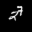

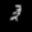

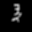

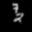

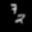

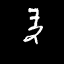

In [33]:
# If using REDS
# train_dataset = REDS(train=True, device=device)
# test_dataset = REDS(train=False, device=device)

# If using moving MNIST : http://www.cs.toronto.edu/~nitish/unsupervised_video/
# This will download all the data
data = torchvision.datasets.MovingMNIST(root='./', split=None,
                                        split_ratio=10, download=True)
train_data = data[0:8000].to('cpu')      # 80% for train
test_data = data[8000:10001].to('cpu')    # 20% for test

def transform_image(image):
    # Performs downsampling and then blurring
    image = torchvision.transforms.functional.resize(image, (32, 32))
    gb = torchvision.transforms.GaussianBlur(kernel_size=(3,3))
    image = gb(image)
    return image
    
def get_sample(data, idx):
    """
    Given a dataset (train/test) and a sample idx, a random sequence
    of 5 LR frames is computed
    """
    num_video_frames = data[idx].size()[0]
    rand_frame_idx = np.random.randint(2, num_video_frames - 2)
    # Get HR frame
    hr_frame = data[idx][rand_frame_idx].to(device)
    # Get LR frames
    lr_frames = [data[idx][k] for k in range(rand_frame_idx-2, rand_frame_idx+3)]
    lr_frames = [transform_image(frame) for frame in lr_frames]
    lr_frames = torch.stack(lr_frames, dim=0).to(device) # permuted to have channel first
    return lr_frames, hr_frame

lr_frames, hr_frame = get_sample(data, 0)
print('Comparing the 5 low-res images to the one high-res one')
for f in lr_frames:
    pil_fr = torchvision.transforms.ToPILImage()(f)
    display(pil_fr)
display(torchvision.transforms.ToPILImage()(hr_frame))

In [34]:
h_in = 32
w_in = 32
c_in = 1
k = 3
s = 1
p = 1
d = 1

conv_h_out = ((h_in + (2*p) - (d*(k-1)) -1) / s) + 1
conv_w_out = ((h_in + (2*p) - (d*(k-1)) -1) / s) + 1

k = 2
s = 2
p = 0
d = 1

pool_h_out = ((conv_h_out + (2*p) - (d*(k-1)) -1) / s) + 1
pool_w_out = ((conv_w_out + (2*p) - (d*(k-1)) -1) / s) + 1

print(pool_h_out, pool_w_out)

16.0 16.0


In [35]:
# Set up loss functions

# perceptual_loss
vgg = torchvision.models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features # removes final classification layer as we don't need it
vgg.to(device)
vgg.eval() # sets the model to evaluation mode, to not update weights/parameters
for param in vgg.parameters():
    param.requires_grad = False # don't calculate gradients after forward passes, reduces computation
    
# A hook function can be used on any nn.module(), like any layer of a neural net
# Depending on whether it's a backwards hook (backprop) or forward hook (forward pass),
# the inputs and outputs of that nn.module can be accessed for that operation
# It's like an event, that each time it happens, the inputs/outputs of that module are saved and then used by vgg_hook
vgg_activations = {3:torch.tensor(0),
                   8:torch.tensor(0),
                   17:torch.tensor(0),
                   26:torch.tensor(0),
                   35:torch.tensor(0)}
def vgg_hook(module, input, output):   
    # Get activations at several layers
    for layer in [3, 8, 17, 26, 35]: # each of the layers we want
        if module == vgg[layer]: 
            vgg_activations[layer] = output
    
for layer in [3, 8, 17, 26, 35]:
    vgg[layer].register_forward_hook(vgg_hook)

def perceptual_loss(generated_img, target_img): # we want a lower value
    # with torch.no_grad():
    _ = vgg(generated_img)
    generated_activations = vgg_activations.copy()
    _ = vgg(target_img)
    target_activations = vgg_activations.copy()
    
    # calculate F1 (mean absolute loss (MAE)) for each activation layer
    mae_loss = []
    for layer in [3, 8, 17, 26, 35]:
        mae = F.l1_loss(generated_activations[layer],
                        target_activations[layer])
        mae_loss.append(mae)
        
    return sum(mae_loss)

# Test if perceptual loss works
lr_imgs1, hr_img1 = get_sample(train_data, 20)
lr_imgs2, hr_img2 = get_sample(train_data, 30)

print(f"Differing video sequences: {perceptual_loss(hr_img1.expand(3,-1,-1).float(), hr_img2.expand(3,-1,-1).float())}")
print(f"Same frame: {perceptual_loss(hr_img2.expand(3,-1,-1).float(), hr_img2.expand(3,-1,-1).float())}")

Differing video sequences: 170.6468963623047
Same frame: 0.0


In [36]:
# Parameters for training/testing
new_model = False
num_epochs = 35
# pq batches take ~ 1 secs, so 1 epoch ~ 1.5 minutes
# mse batches take ~ 1 secs, so 1 epoch ~ 1.5 minutes

# To run an entire epoch through takes ~ 3 minutes for both models
skip_graphs = False
learning_rate = 0.000001
batch_size = 100
train = True           # if false, then the models will initialize with best weights (for inference/testing)

In [37]:
# torch.cuda.empty_cache()
# Can be either 'mse' or 'pq'
loss_function = 'pq'
path = f'saved_models/recon_model_{loss_function}.pt'
# Initialize Model architecture
pq_recon_model = reconstructor(device=device).to(device)
if new_model:
    # Train/Test 
    # Mean Square Error/Perceptual Quality
    train_mse_loss = []
    train_pq_loss = []
    test_mse_loss = []
    test_pq_loss = []
    best_val_loss = float('inf')
else:
    # Get dictionary of info
    old_model = torch.load(path, map_location=device)
    # load model with previous weights/parameters
    pq_recon_model.load_state_dict(old_model[0])
    # update previous lists of loss
    if loss_function == 'mse':
        train_mse_loss = old_model[1]
        test_mse_loss = old_model[2]
    else:
        train_pq_loss = old_model[1]
        test_pq_loss = old_model[2]
    best_val_loss = old_model[3]
    
if train:
    start_time = time.time()
    prev_batch_time = start_time
    mse = nn.MSELoss()
    optimizer = torch.optim.Adam(params=pq_recon_model.parameters(),
                                 lr=learning_rate)
    for epoch in range(num_epochs):
        # Training
        pq_recon_model.train()
        running_loss = 0
        epoch_running_loss = 0
        for i in range(len(train_data)):
            # Get data sample
            lr_imgs, hr_img = get_sample(train_data, i)
            lr_imgs = lr_imgs.float()
            hr_img = hr_img.float().to(device)
            # Do prediction
            hr_pred = pq_recon_model(lr_imgs)
            # calculate loss
            if loss_function == 'mse':
                loss = mse(hr_pred, 
                           hr_img)
            else:
                loss = perceptual_loss(hr_pred.expand(3,-1,-1), 
                                       hr_img.expand(3,-1,-1))
            # propagate loss through weights to find gradients
            # and also adds gradients up
            loss.backward()
            running_loss += loss.item()
            epoch_running_loss += loss.item()
            del lr_imgs, hr_img, hr_pred
            
            if i % batch_size == 0 and i != 0:
                optimizer.step()
                optimizer.zero_grad()
                avg_batch_loss = running_loss / batch_size
                running_loss = 0
                print(f'Epoch {epoch + 1}/{num_epochs}')
                print(f'Batch: {int((i+1)/batch_size)} / {int(len(train_data)/batch_size)}')
                print(f'Avg. Training Loss: {avg_batch_loss:.4f}')
                # print(f'W-values: {pq_recon_model.w}')
                # for name, param in pq_recon_model.named_parameters():
                #     if param.requires_grad and name=='lr.conv3.bias':
                #         print(param.data[0:5])
                # Calculate batch training time   
                curr_time = time.time()
                time_diff = (curr_time - prev_batch_time) # in seconds
                minutes, seconds = divmod(time_diff, 60)
                minutes = int(minutes)
                seconds = int(seconds)
                print(f'Training Time:')
                print(f'{minutes} minutes:{seconds} seconds')
                print()
                prev_batch_time = curr_time
                
        avg_epoch_loss = epoch_running_loss / len(train_data)
        if loss_function == 'mse':
            train_mse_loss.append(avg_epoch_loss)
        else:
            train_pq_loss.append(avg_epoch_loss)
        print(f'Epoch Avg. Training Loss: {avg_epoch_loss:.4f}')
            
        # Testing
        pq_recon_model.eval()
        running_loss = 0
        epoch_running_loss = 0
        for i in range(len(test_data)):
            with torch.no_grad():
                # Get data sample
                lr_imgs, hr_img = get_sample(test_data, i)
                hr_img = hr_img.float().to(device)
                # Do prediction
                hr_pred = pq_recon_model(lr_imgs)
                hr_pred.requires_grad = True
                # calculate loss
                if loss_function == 'mse':
                    loss = mse(hr_pred, 
                               hr_img)
                else:
                    loss = perceptual_loss(hr_pred.expand(3,-1,-1), 
                                           hr_img.expand(3,-1,-1))
                running_loss += loss.item()
                epoch_running_loss += loss.item()
                del lr_imgs, hr_img, hr_pred
                
                if i%batch_size == 0 and i != 0:
                    avg_batch_loss = running_loss / batch_size
                    running_loss = 0
                    print(f'Epoch {epoch + 1}/{num_epochs}')
                    print(f'Batch: {int((i+1)/batch_size)} / {int(len(test_data)/batch_size)}')
                    print(f'Avg. Testing Loss: {avg_batch_loss:.4f}')
                    # print(f'W-values: {pq_recon_model.w}')
                    # for name, param in pq_recon_model.named_parameters():
                    #     if param.requires_grad and name=='lr.conv3.bias':
                    #         print(param.data[0:5])
                    # Calculate batch training time   
                    curr_time = time.time()
                    time_diff = (curr_time - prev_batch_time) # in seconds
                    minutes, seconds = divmod(time_diff, 60)
                    minutes = int(minutes)
                    seconds = int(seconds)
                    print(f'Testing Time:')
                    print(f'{minutes} minutes:{seconds} seconds')
                    print()
                    prev_batch_time = curr_time
                    
        avg_epoch_loss = epoch_running_loss / len(test_data)
        if loss_function == 'mse':
            test_mse_loss.append(avg_epoch_loss)
        else:
            test_pq_loss.append(avg_epoch_loss)
        print(f'Epoch Avg. Testing Loss: {avg_epoch_loss:.4f}')
        
        # Capture results
        if avg_epoch_loss < best_val_loss:
            # print(avg_running_loss, best_val_loss)
            best_val_loss = avg_epoch_loss
            save_dict = dict()
            save_dict[0] = pq_recon_model.state_dict()
            if loss_function == 'mse':
                save_dict[1] = train_mse_loss
                save_dict[2] = test_mse_loss
            else:
                save_dict[1] = train_pq_loss
                save_dict[2] = test_pq_loss
            save_dict[3] = best_val_loss
            torch.save(save_dict, path)
            
        # Calculate epoch training/testing time
        if epoch==0:
            curr_time = time.time()
            prev_time = start_time
        else:
            prev_time = curr_time
            curr_time = time.time()
        time_diff = (curr_time - prev_time) # in seconds
        minutes, seconds = divmod(time_diff, 60)
        minutes = int(minutes)
        seconds = int(seconds)
        
        print(f'Epoch Time:')
        print(f'{minutes} minutes:{seconds} seconds')
        print()
        print(*"====================")
        print()

Epoch 1/35
Batch: 1 / 80
Avg. Training Loss: 110.7255
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 2 / 80
Avg. Training Loss: 107.4833
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 3 / 80
Avg. Training Loss: 109.6489
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 4 / 80
Avg. Training Loss: 107.4358
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 5 / 80
Avg. Training Loss: 108.4372
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 6 / 80
Avg. Training Loss: 108.0516
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 7 / 80
Avg. Training Loss: 107.6498
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 8 / 80
Avg. Training Loss: 110.0014
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 9 / 80
Avg. Training Loss: 109.8424
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 10 / 80
Avg. Training Loss: 106.9546
Training Time:
0 minutes:1 seconds

Epoch 1/35
Batch: 11 / 80
Avg. Training Loss: 108.3936
Training Time:
0 minutes:1 seconds

Epoch 1/

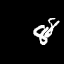

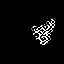

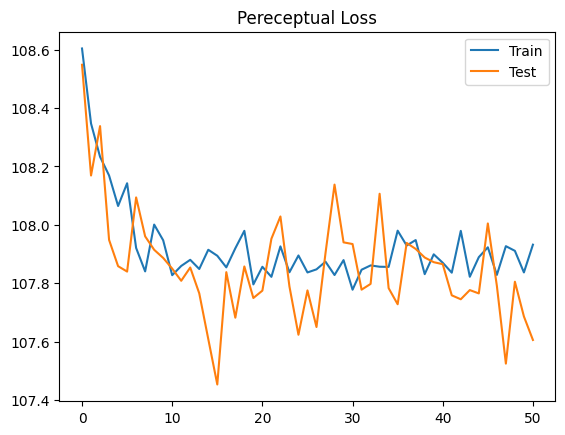

In [38]:
if not skip_graphs:
    # Plotting avg. training and testing loss for PQ-trained model
    plt.plot(train_pq_loss)
    plt.plot(test_pq_loss)
    plt.title("Pereceptual Loss")
    plt.legend(['Train', 'Test'])
    
    lr_imgs, hr_img = get_sample(test_data, 100)
    hr_pred = pq_recon_model(lr_imgs)
    
    # mse_loss = mse(hr_pred, hr_img)
    # perceptual_loss = perceptual_loss(hr_pred, hr_img)
    # print(f'MSE Loss: {mse_loss:.4f}')
    # print(f'Perceptual Loss: {perceptual_loss:.4f}')
    
    display(torchvision.transforms.ToPILImage()(hr_img))
    display(torchvision.transforms.ToPILImage()(hr_pred))

In [ ]:
# torch.cuda.empty_cache()
# Can be either 'mse' or 'pq'
loss_function = 'mse'
path = f'saved_models/recon_model_{loss_function}.pt'
# Initialize Model architecture
mse_recon_model = reconstructor(device=device).to(device)
if new_model:
    # Train/Test 
    # Mean Square Error/Perceptual Quality
    train_mse_loss = []
    train_pq_loss = []
    test_mse_loss = []
    test_pq_loss = []
    best_val_loss = float('inf')
else:
    # Get dictionary of info
    old_model = torch.load(path, map_location=device)
    # load model with previous weights/parameters
    mse_recon_model.load_state_dict(old_model[0])
    # update previous lists of loss
    if loss_function == 'mse':
        train_mse_loss = old_model[1]
        test_mse_loss = old_model[2]
    else:
        train_pq_loss = old_model[1]
        test_pq_loss = old_model[2]
    best_val_loss = old_model[3]
    
if train:
    start_time = time.time()
    prev_batch_time = start_time
    mse = nn.MSELoss()
    optimizer = torch.optim.Adam(params=mse_recon_model.parameters(),
                                 lr=learning_rate)
    for epoch in range(num_epochs):
        # Training
        mse_recon_model.train()
        running_loss = 0
        epoch_running_loss = 0
        for i in range(len(train_data)):
            # Get data sample
            lr_imgs, hr_img = get_sample(train_data, i)
            hr_img = hr_img.float().to(device)
            # Do prediction
            hr_pred = mse_recon_model(lr_imgs)
            # calculate loss
            if loss_function == 'mse':
                loss = mse(hr_pred, 
                           hr_img)
            else:
                loss = perceptual_loss(hr_pred.expand(3,-1,-1), 
                                       hr_img.expand(3,-1,-1))
            # propagate loss through weights to find gradients
            # and also adds gradients up
            loss.backward()
            running_loss += loss.item()
            epoch_running_loss += loss.item()
            del lr_imgs, hr_img, hr_pred
            
            if i % batch_size == 0 and i != 0:
                optimizer.step()
                optimizer.zero_grad()
                avg_batch_loss = running_loss / batch_size
                running_loss = 0
                print(f'Epoch {epoch + 1}/{num_epochs}')
                print(f'Batch: {int((i+1)/batch_size)} / {int(len(train_data)/batch_size)}')
                print(f'Avg. Training Loss: {avg_batch_loss:.4f}')
                # print(f'W-values: {mse_recon_model.w}')
                # for name, param in mse_recon_model.named_parameters():
                #     if param.requires_grad and name=='lr.conv3.bias':
                #         print(param.data[0:5])
                # Calculate batch training time   
                curr_time = time.time()
                time_diff = (curr_time - prev_batch_time) # in seconds
                minutes, seconds = divmod(time_diff, 60)
                minutes = int(minutes)
                seconds = int(seconds)
                print(f'Training Time:')
                print(f'{minutes} minutes:{seconds} seconds')
                print()
                prev_batch_time = curr_time
                
        avg_epoch_loss = epoch_running_loss / len(train_data)
        if loss_function == 'mse':
            train_mse_loss.append(avg_epoch_loss)
        else:
            train_pq_loss.append(avg_epoch_loss)
        print(f'Epoch Avg. Training Loss: {avg_epoch_loss:.4f}')
            
        # Testing
        mse_recon_model.eval()
        running_loss = 0
        epoch_running_loss = 0
        for i in range(len(test_data)):
            with torch.no_grad():
                # Get data sample
                lr_imgs, hr_img = get_sample(test_data, i)
                hr_img = hr_img.float().to(device)
                # Do prediction
                hr_pred = mse_recon_model(lr_imgs)
                hr_pred.requires_grad = True
                # calculate loss
                if loss_function == 'mse':
                    loss = mse(hr_pred, 
                               hr_img)
                else:
                    loss = perceptual_loss(hr_pred.expand(3,-1,-1), 
                                           hr_img.expand(3,-1,-1))
                running_loss += loss.item()
                epoch_running_loss += loss.item()
                del lr_imgs, hr_img, hr_pred
                
                if i%batch_size == 0 and i != 0:
                    avg_batch_loss = running_loss / batch_size
                    running_loss = 0
                    print(f'Epoch {epoch + 1}/{num_epochs}')
                    print(f'Batch: {int((i+1)/batch_size)} / {int(len(test_data)/batch_size)}')
                    print(f'Avg. Testing Loss: {avg_batch_loss:.4f}')
                    # print(f'W-values: {mse_recon_model.w}')
                    # for name, param in mse_recon_model.named_parameters():
                    #     if param.requires_grad and name=='lr.conv3.bias':
                    #         print(param.data[0:5])
                    # Calculate batch training time   
                    curr_time = time.time()
                    time_diff = (curr_time - prev_batch_time) # in seconds
                    minutes, seconds = divmod(time_diff, 60)
                    minutes = int(minutes)
                    seconds = int(seconds)
                    print(f'Testing Time:')
                    print(f'{minutes} minutes:{seconds} seconds')
                    print()
                    prev_batch_time = curr_time
                    
        avg_epoch_loss = epoch_running_loss / len(test_data)
        if loss_function == 'mse':
            test_mse_loss.append(avg_epoch_loss)
        else:
            test_pq_loss.append(avg_epoch_loss)
        print(f'Epoch Avg. Testing Loss: {avg_epoch_loss:.4f}')
        
        # Capture results
        if avg_epoch_loss < best_val_loss:
            # print(avg_running_loss, best_val_loss)
            best_val_loss = avg_epoch_loss
            save_dict = dict()
            save_dict[0] = mse_recon_model.state_dict()
            if loss_function == 'mse':
                save_dict[1] = train_mse_loss
                save_dict[2] = test_mse_loss
            else:
                save_dict[1] = train_pq_loss
                save_dict[2] = test_pq_loss
            save_dict[3] = best_val_loss
            torch.save(save_dict, path)
            
        # Calculate epoch training/testing time
        if epoch==0:
            curr_time = time.time()
            prev_time = start_time
        else:
            prev_time = curr_time
            curr_time = time.time()
        time_diff = (curr_time - prev_time) # in seconds
        minutes, seconds = divmod(time_diff, 60)
        minutes = int(minutes)
        seconds = int(seconds)
        
        print(f'Epoch Time:')
        print(f'{minutes} minutes:{seconds} seconds')
        print()
        print(*"====================")
        print()

Epoch 1/35
Batch: 1 / 80
Avg. Training Loss: 2820.4551
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 2 / 80
Avg. Training Loss: 2671.9180
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 3 / 80
Avg. Training Loss: 2781.0089
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 4 / 80
Avg. Training Loss: 2747.7884
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 5 / 80
Avg. Training Loss: 2732.2063
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 6 / 80
Avg. Training Loss: 2730.1774
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 7 / 80
Avg. Training Loss: 2768.8663
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 8 / 80
Avg. Training Loss: 2756.8288
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 9 / 80
Avg. Training Loss: 2825.3430
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 10 / 80
Avg. Training Loss: 2725.1832
Training Time:
0 minutes:0 seconds

Epoch 1/35
Batch: 11 / 80
Avg. Training Loss: 2736.9326
Training Time:
0 minutes:0 second

In [ ]:
if not skip_graphs:
    # Plotting avg. training and testing loss for MSE-trained model
    plt.plot(train_mse_loss)
    plt.plot(test_mse_loss)
    plt.title("MSE Loss")
    plt.legend(['Train', 'Test'])
    
    lr_imgs, hr_img = get_sample(test_data, 25)
    hr_pred = mse_recon_model(lr_imgs)
    
    # mse_loss = mse(hr_pred, hr_img)
    # perceptual_loss = perceptual_loss(hr_pred, hr_img)
    # print(f'MSE Loss: {mse_loss:.4f}')
    # print(f'Perceptual Loss: {perceptual_loss:.4f}')
    
    display(torchvision.transforms.ToPILImage()(hr_img))
    display(torchvision.transforms.ToPILImage()(hr_pred))

In [ ]:
data[20].shape

In [ ]:
# Show how predictions varied
pq_recon_model.eval()
mse_recon_model.eval()

fig, axes = plt.subplots(5, 3)
for i in range(5):
    for j in range(3):
        axes[i,j].axis('off')
axes[0,0].title.set_text('Ground Truth')
axes[0,1].title.set_text('PQ Predicted')
axes[0,2].title.set_text('MSE Predicted')
for k in range(5): # Random inference values
    with torch.no_grad():
        lr_imgs, hr_img = get_sample(data, k)
        hr_img = hr_img.squeeze().to('cpu').numpy()
        hr_pred_pq = pq_recon_model(lr_imgs)
        hr_pred_pq = hr_pred_pq.squeeze().to('cpu').numpy()
        hr_pred_mse = mse_recon_model(lr_imgs)
        hr_pred_mse = hr_pred_mse.squeeze().to('cpu').numpy()
        axes[k,0].imshow(hr_img)
        axes[k,1].imshow(hr_pred_pq)
        axes[k,2].imshow(hr_pred_mse)
        
plt.savefig('report/figures/predictions.png')
plt.show()

In [ ]:
axes

In [ ]:
# Create GIFs

In [ ]:
if not skip_graphs:
    idx = np.random.randint(0, 10000)
    
    lr_frames, hr_frame = get_sample(data, idx)
    print('Comparing the 5 low-res images to the one high-res one')
    for j in range(len(lr_frames)):
        f = lr_frames[j]
        pil_fr = torchvision.transforms.ToPILImage()(f)
        pil_fr.save(f'report/figures/Samples/{idx}_{j}_lr.png')
        display(pil_fr)
    pil_hr = torchvision.transforms.ToPILImage()(hr_frame)
    pil_hr.save(f'report/figures/Samples/{idx}_hr.png')
    display(pil_hr)

In [ ]:
# # torch.cuda.empty_cache()
# # Can be either 'mse' or 'pq'
# loss_function = 'pq'
# path = f'saved_models/diff_model_{loss_function}.pt'
# # Initialize Model architecture
# pq_diff_model = diffusion_vsr(s=torch.tensor(0.0008), 
#                            train_T=torch.tensor(1000), 
#                            infer_T=torch.tensor(1000),
#                               device=device).to(device)
# if new_model:
#     # Train/Test 
#     # Mean Square Error/Perceptual Quality
#     train_mse_loss = []
#     train_pq_loss = []
#     test_mse_loss = []
#     test_pq_loss = []
#     best_val_loss = float('inf')
# else:
#     # Get dictionary of info
#     old_model = torch.load(path, map_location=device)
#     # load model with previous weights/parameters
#     pq_diff_model.load_state_dict(old_model[0])
#     # update previous lists of loss
#     if loss_function == 'mse':
#         train_mse_loss = old_model[1]
#         test_mse_loss = old_model[2]
#     else:
#         train_pq_loss = old_model[1]
#         test_pq_loss = old_model[2]
#     best_val_loss = old_model[3]
#     
# if train:
#     start_time = time.time()
#     mse = nn.MSELoss()
#     optimizer = torch.optim.Adam(params=pq_diff_model.parameters(),
#                                  lr=learning_rate)
#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch + 1}/{num_epochs}')
#         # Training
#         pq_diff_model.train()
#         pq_diff_model.calc_train_steps()
#         running_loss = 0
#         for i in range(len(train_data)):
#             lr_imgs, hr_img = get_sample(train_data, i)
#             # random t-step to predict
#             t = torch.randint(low=0, high=1000, size=(1,)).to(device)
#             # hr_img after t steps of noise addition
#             hr_t = pq_diff_model.add_noise(hr_img, t)
#             # hr_img after t-1 steps of noise addition
#             # This is what we want the model to predict (bc we want the reverse process)
#             hr_tmin1 = pq_diff_model.add_noise(hr_img, t-1)
#             # Now, let's do one pass through the model
#             pred_hr_tmin1 = pq_diff_model(hr_img, lr_imgs, t)
#             if loss_function == 'mse':
#                 loss = mse(pred_hr_tmin1, 
#                            hr_tmin1)
#             else:
#                 loss = perceptual_loss(pred_hr_tmin1.expand(3,-1,-1), 
#                                        hr_tmin1.expand(3,-1,-1))
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#             del lr_imgs, hr_img, t, hr_t, hr_tmin1, pred_hr_tmin1
#             running_loss += loss.item()
#             
#             if i%batch_size == 0 and i != 0:
#                 avg_running_loss = running_loss / batch_size
#                 running_loss = 0
#                 if loss_function == 'mse':
#                     train_mse_loss.append(avg_running_loss)
#                 else:
#                     train_pq_loss.append(avg_running_loss)
#                 print(f'Batch Avg. Training Loss: {avg_running_loss:.4f}')
#             
#         # Testing
#         pq_diff_model.eval()
#         pq_diff_model.calc_test_steps()
#         running_loss = 0
#         for i in range(len(test_data)):
#             with torch.no_grad():
#                 lr_imgs, hr_img = get_sample(test_data, i)
#                 # random t-step to predict
#                 t = torch.randint(low=0, high=50, size=(1,)).to('cpu')
#                 # hr_img after t steps of noise addition
#                 hr_t = pq_diff_model.add_noise(hr_img, t)
#                 # hr_img after t-1 steps of noise addition
#                 # This is what we want the model to predict (bc we want the reverse process)
#                 hr_tmin1 = pq_diff_model.add_noise(hr_img, t-1)
#                 # Now, let's do one pass through the model
#                 pred_hr_tmin1 = pq_diff_model(hr_t, lr_imgs, t)
#                 if loss_function == 'mse':
#                     loss = mse(pred_hr_tmin1, hr_tmin1)
#                 else:
#                     loss = perceptual_loss(pred_hr_tmin1.expand(3,-1,-1), 
#                                            hr_tmin1.expand(3,-1,-1))
#                 running_loss += loss.item()
#                 del lr_imgs, hr_img, t, hr_t, hr_tmin1, pred_hr_tmin1
#             
#             if i%batch_size == 0 and i != 0:
#                 avg_running_loss = running_loss / batch_size
#                 running_loss = 0
#                 if loss_function == 'mse':
#                     test_mse_loss.append(avg_running_loss)
#                 else:
#                     test_pq_loss.append(avg_running_loss)
#                 print(f'Batch Avg. Testing Loss: {avg_running_loss:.4f}')
#         
#                 # Capture results
#                 if avg_running_loss < best_val_loss:
#                     # print(avg_running_loss, best_val_loss)
#                     best_val_loss = avg_running_loss
#                     save_dict = dict()
#                     save_dict[0] = pq_diff_model.state_dict()
#                     if loss_function == 'mse':
#                         save_dict[1] = train_mse_loss
#                         save_dict[2] = test_mse_loss
#                     else:
#                         save_dict[1] = train_pq_loss
#                         save_dict[2] = test_pq_loss
#                     save_dict[3] = best_val_loss
#                     torch.save(save_dict, path)
#             
#         # Calculate epoch training/testing time
#         if epoch==0:
#             prev_time = start_time
#         else:
#             prev_time = curr_time    
#         curr_time = time.time()
#         time_diff = (curr_time - prev_time) # in seconds
#         minutes, seconds = divmod(time_diff, 60)
#         minutes = int(minutes)
#         seconds = int(seconds)
#         
#         print(f'Time:')
#         print(f'{minutes} minutes:{seconds} seconds')
#         print()
# 
# # Plotting avg. training and testing loss for MSE-trained model
# plt.plot(train_pq_loss)
# plt.plot(test_pq_loss)
# plt.title("Pereceptual Loss")
# plt.legend(['Train', 'Test'])
# 
# ### Testing diffusion model code
# 
# torch.cuda.empty_cache()
# # Can be either 'mse' or 'pq'
# loss_function = 'mse'
# path = f'saved_models/diff_model_{loss_function}.pt'
# # Initialize Model architecture
# mse_diff_model = diffusion_vsr(s=torch.tensor(0.0008), 
#                            train_T=torch.tensor(1000), 
#                            infer_T=torch.tensor(50)).to(device)
# if new_model:
#     # Train/Test 
#     # Mean Square Error/Perceptual Quality
#     train_mse_loss = []
#     train_mse_loss = []
#     test_mse_loss = []
#     test_mse_loss = []
#     best_val_loss = float('inf')
# else:
#     # Get dictionary of info
#     old_model = torch.load(path, map_location=device)
#     # load model with previous weights/parameters
#     mse_diff_model.load_state_dict(old_model[0])
#     # update previous lists of loss
#     if loss_function == 'mse':
#         train_mse_loss = old_model[1]
#         test_mse_loss = old_model[2]
#     else:
#         train_pq_loss = old_model[1]
#         test_pq_loss = old_model[2]
#     best_val_loss = old_model[3]
#     
# if train:
#     start_time = time.time()
#     mse = nn.MSELoss()
#     optimizer = torch.optim.Adam(params=mse_diff_model.parameters(),
#                                  lr=learning_rate)
#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch + 1}/{num_epochs}')
#         # Training
#         mse_diff_model.train()
#         mse_diff_model.calc_train_steps()
#         running_loss = 0
#         for i in range(len(train_data)):
#             lr_imgs, hr_img = get_sample(train_data, i)
#             # random t-step to predict
#             t = torch.randint(low=0, high=1000, size=(1,)).to(device)
#             # hr_img after t steps of noise addition
#             hr_t = mse_diff_model.add_noise(hr_img, t)
#             # hr_img after t-1 steps of noise addition
#             # This is what we want the model to predict (bc we want the reverse process)
#             hr_tmin1 = mse_diff_model.add_noise(hr_img, t-1)
#             # Now, let's do one pass through the model
#             pred_hr_tmin1 = mse_diff_model(hr_img, lr_imgs, t)
#             if loss_function == 'mse':
#                 loss = mse(pred_hr_tmin1, 
#                            hr_tmin1)
#             else:
#                 loss = perceptual_loss(pred_hr_tmin1.expand(3,-1,-1), 
#                                        hr_tmin1.expand(3,-1,-1))
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#             running_loss += loss.item()
#             
#             if i%batch_size == 0 and i != 0:
#                 avg_running_loss = running_loss / batch_size
#                 running_loss = 0
#                 if loss_function == 'mse':
#                     train_mse_loss.append(avg_running_loss)
#                 else:
#                     train_pq_loss.append(avg_running_loss)
#                 print(f'Batch Avg. Training Loss: {avg_running_loss:.4f}')
#             
#         # Testing
#         mse_diff_model.eval()
#         mse_diff_model.calc_test_steps()
#         running_loss = 0
#         for i in range(len(test_data)):
#             with torch.no_grad():
#                 lr_imgs, hr_img = get_sample(test_data, i)
#                 # random t-step to predict
#                 t = torch.randint(low=0, high=50, size=(1,)).to(device)
#                 # hr_img after t steps of noise addition
#                 hr_t = mse_diff_model.add_noise(hr_img, t)
#                 # hr_img after t-1 steps of noise addition
#                 # This is what we want the model to predict (bc we want the reverse process)
#                 hr_tmin1 = mse_diff_model.add_noise(hr_img, t-1)
#                 # Now, let's do one pass through the model
#                 pred_hr_tmin1 = mse_diff_model(hr_t, lr_imgs, t)
#                 if loss_function == 'mse':
#                     loss = mse(pred_hr_tmin1, hr_tmin1)
#                 else:
#                     loss = perceptual_loss(pred_hr_tmin1.expand(3,-1,-1), 
#                                            hr_tmin1.expand(3,-1,-1))
#                 running_loss += loss.item()
#             
#             if i%batch_size == 0 and i != 0:
#                 avg_running_loss = running_loss / batch_size
#                 running_loss = 0
#                 if loss_function == 'mse':
#                     test_mse_loss.append(avg_running_loss)
#                 else:
#                     test_pq_loss.append(avg_running_loss)
#                 print(f'Batch Avg. Testing Loss: {avg_running_loss:.4f}')
#         
#                 # Capture results
#                 if avg_running_loss < best_val_loss:
#                     # print(avg_running_loss, best_val_loss)
#                     best_val_loss = avg_running_loss
#                     save_dict = dict()
#                     save_dict[0] = mse_diff_model.state_dict()
#                     if loss_function == 'mse':
#                         save_dict[1] = train_mse_loss
#                         save_dict[2] = test_mse_loss
#                     else:
#                         save_dict[1] = train_mse_loss
#                         save_dict[2] = test_mse_loss
#                     save_dict[3] = best_val_loss
#                     torch.save(save_dict, path)
#             
#         # Calculate epoch training/testing time
#         if epoch==0:
#             prev_time = start_time
#         else:
#             prev_time = curr_time    
#         curr_time = time.time()
#         time_diff = (curr_time - prev_time) # in seconds
#         minutes, seconds = divmod(time_diff, 60)
#         minutes = int(minutes)
#         seconds = int(seconds)
#         
#         print(f'Time:')
#         print(f'{minutes} minutes:{seconds} seconds')
#         print()
#         
# # Plotting avg. training and testing loss for MSE-trained model
# plt.plot(train_mse_loss)
# plt.plot(test_mse_loss)
# plt.title("MSE Loss")
# plt.legend(['Train', 'Test'])